# import thư viện

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/

Mounted at /content/drive
/content


In [2]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 27.2 MB/s eta 0:00:00


In [4]:
from tqdm import tqdm 

from sklearn.metrics import average_precision_score
import numpy as np

In [5]:
import os
import argparse
import datetime
import time
import pandas as pd
import importlib
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.backends.cudnn as cudnn
import sys
import os

py_file_location = "/content/drive/MyDrive/KLTN_19521818/osr_closed_set_all_you_need-main"
sys.path.append(os.path.abspath(py_file_location))
import methods
from methods.ARPL.core import evaluation
#from methods.ARPL.arpl_models.arpl_models import classifier32ABN
from methods.ARPL.arpl_utils import AverageMeter
from methods.MSP.test_msp import test
#from methods.ARPL.arpl_models.arpl_models import classifier32
from utils.utils import init_experiment, seed_torch, str2bool, get_default_hyperparameters
from utils.schedulers import get_scheduler
from data.open_set_datasets import get_class_splits, get_datasets
from models.model_utils import get_model

from config import exp_root
from models.classifier32  import classifier32

In [6]:
parser = argparse.ArgumentParser("Training")
parser.add_argument('-f')

parser.add_argument('--dataset', type=str, default='cifar-10-100', help="")
parser.add_argument('--out-num', type=int, default=10, help='For cifar-10-100')
parser.add_argument('--image_size', type=int, default=32)

# optimization
parser.add_argument('--optim', type=str, default=None, help="Which optimizer to use {adam, sgd}")
parser.add_argument('--batch_size', type=int, default=128)
parser.add_argument('--lr', type=float, default=0.1, help="learning rate for model")
parser.add_argument('--weight_decay', type=float, default=1e-4, help="LR regularisation on weights")
parser.add_argument('--gan_lr', type=float, default=0.0002, help="learning rate for gan")
parser.add_argument('--max-epoch', type=int, default=50)
parser.add_argument('--scheduler', type=str, default='cosine_warm_restarts')
parser.add_argument('--temp', type=float, default=1.0, help="temp")
parser.add_argument('--num_restarts', type=int, default=2, help='How many restarts for cosine_warm_restarts schedule')
parser.add_argument('--num-centers', type=int, default=1)

# model
parser.add_argument('--loss', type=str, default='ARPLoss')
parser.add_argument('--weight-pl', type=float, default=0.1, help="weight for center loss")
parser.add_argument('--label_smoothing', type=float, default=None, help="Smoothing constant for label smoothing."
                                                                        "No smoothing if None or 0")
parser.add_argument('--beta', type=float, default=0.1, help="weight for entropy loss")
parser.add_argument('--model', type=str, default='classifier32')
parser.add_argument('--resnet50_pretrain', type=str, default='places_moco',
                        help='Which pretraining to use if --model=timm_resnet50_pretrained.'
                             'Options are: {iamgenet_moco, places_moco, places}', metavar='BOOL')
parser.add_argument('--feat_dim', type=int, default=128, help="Feature vector dim, only for classifier32 at the moment")

# aug
parser.add_argument('--transform', type=str, default='rand-augment')
parser.add_argument('--rand_aug_m', type=int, default=6)
parser.add_argument('--rand_aug_n', type=int, default=1)

# misc
parser.add_argument('--num_workers', default=4, type=int)
parser.add_argument('--split_train_val', default=False, type=str2bool,
                        help='Subsample training set to create validation set', metavar='BOOL')
parser.add_argument('--use_default_parameters', default=False, type=str2bool,
                    help='Set to True to use optimized hyper-parameters from paper', metavar='BOOL')
parser.add_argument('--device', default='cuda:0', type=str, help='Which GPU to use')
parser.add_argument('--gpus', default=[0], type=int, nargs='+',
                        help='device ids assignment (e.g 0 1 2 3)')
parser.add_argument('--nz', type=int, default=100)
parser.add_argument('--ns', type=int, default=1)
parser.add_argument('--eval-freq', type=int, default=1)
parser.add_argument('--print-freq', type=int, default=100)
parser.add_argument('--checkpt_freq', type=int, default=20)
parser.add_argument('--gpu', type=str, default='0')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--use-cpu', action='store_true')
parser.add_argument('--eval', action='store_true', help="Eval", default=False)
parser.add_argument('--cs', action='store_true', help="Confusing Sample", default=False)
parser.add_argument('--train_feat_extractor', default=True, type=str2bool,
                        help='Train feature extractor (only implemented for renset_50_faces)', metavar='BOOL')
parser.add_argument('--split_idx', default=0, type=int, help='0-4 OSR splits for each dataset')
parser.add_argument('--use_softmax_in_eval', default=True, type=str2bool,
                        help='Do we use softmax or logits for evaluation', metavar='BOOL')


_StoreAction(option_strings=['--use_softmax_in_eval'], dest='use_softmax_in_eval', nargs=None, const=None, default=True, type=<function str2bool at 0x7f26c53dd5e0>, choices=None, help='Do we use softmax or logits for evaluation', metavar='BOOL')

# Load dữ liệu test

In [7]:
args = parser.parse_args()

In [8]:
args.train_classes, args.open_set_classes = get_class_splits(args.dataset, args.split_idx,
                                                                     cifar_plus_n=args.out_num)

In [9]:
args.train_classes

[4, 7, 9, 1]

In [10]:
datasets,train_class,test_class_unkown = get_datasets(args.dataset, transform=args.transform, train_classes=args.train_classes,
                                open_set_classes=args.open_set_classes, balance_open_set_eval=True,
                                split_train_val=args.split_train_val, image_size=args.image_size, seed=args.seed,
                                args=args)

Loading datasets...


In [11]:
train=datasets['test_known']

In [12]:
train.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [14]:
name=['deer','horse','truck','automobile']

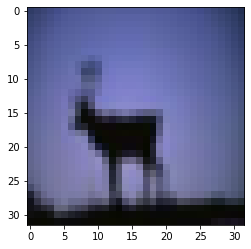

In [15]:
img=train.data[1]
plt.imshow(img)

In [16]:
dataloaders = {}
for k, v, in datasets.items():
            shuffle = True if k == 'train' else False
            dataloaders[k] = DataLoader(v, batch_size=args.batch_size,
                                        shuffle=shuffle, sampler=None, num_workers=args.num_workers)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
trainloader = dataloaders['train']
testloader = dataloaders['val']
outloader = dataloaders['test_unknown']

In [18]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

test_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

# Load model pretrained

In [19]:
def load_model(path_file_model=''):
  model=classifier32(num_classes=4)
  model = nn.DataParallel(model).cuda()
  pretrain=torch.load(path_file_model)
  model.load_state_dict(pretrain)
  return model
  



# Read ảnh

In [ ]:
import cv2

In [ ]:
def read_image(path_file_image,transform):
  img=cv2.imread(path_file_image)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  img=test_transform(img)
  img1=img.unsqueeze(0)
  return img1

# Predict a image

In [20]:
options = vars(args)
options.update(
            {
                'item':     1,
                'known':    args.train_classes,
                'unknown':  args.open_set_classes,
                'img_size': 32,
                'dataloaders': dataloaders,
                'num_classes': len(args.train_classes)
            }
        )


In [21]:
torch.manual_seed(options['seed'])
os.environ['CUDA_VISIBLE_DEVICES'] = options['gpu']
use_gpu = torch.cuda.is_available()
if options['use_cpu']: use_gpu = False

if use_gpu:
        print("Currently using GPU: {}".format(options['gpu']))
        cudnn.benchmark = False
        torch.cuda.manual_seed_all(options['seed'])
else:
        print("Currently using CPU")


Currently using GPU: 0


In [22]:
options.update(
        {
            'feat_dim': 128,
            'use_gpu':  use_gpu
        }
    )

In [23]:
Loss = importlib.import_module('methods.ARPL.loss.'+options['loss'])
criterion = getattr(Loss, options['loss'])(**options)

In [24]:
criterion.state_dict()

OrderedDict([('points',
              tensor([[-1.5256e-01, -7.5023e-02, -6.5398e-02, -1.6095e-01, -1.0017e-02,
                       -6.0919e-02, -9.7977e-02, -1.6091e-01, -7.1214e-02,  3.0372e-02,
                       -7.7731e-02, -2.5146e-02, -2.2227e-02,  1.6871e-01,  2.2843e-02,
                        4.6764e-02, -6.9697e-02, -1.1608e-01,  6.9954e-02,  1.9908e-02,
                        8.6569e-02,  2.4440e-02, -6.6291e-02,  8.0731e-02,  1.1017e-01,
                       -1.7594e-02, -2.2456e-01, -1.4465e-01,  6.1155e-03, -6.1774e-02,
                       -7.9807e-02, -1.3162e-02,  1.8793e-01, -7.2132e-03,  1.5777e-02,
                       -7.7345e-02,  1.9906e-02,  4.5703e-03,  1.5296e-02, -4.7568e-02,
                       -1.1102e-02,  2.9274e-02, -1.5785e-02, -2.8787e-03,  2.3571e-01,
                       -1.0373e-01,  1.5748e-01, -6.2985e-02, -9.2739e-02,  5.4514e-02,
                        6.6280e-03, -4.3704e-02,  7.6260e-02,  4.4151e-02,  1.1651e-01,
        

In [25]:

criterion = criterion.cuda()
criterion.load_state_dict(torch.load('/content/drive/MyDrive/KLTN_19521818/osr_closed_set_all_you_need-main/pretrained/ARPL_loss.pth'))
model_arp=load_model(path_file_model='/content/drive/MyDrive/KLTN_19521818/osr_closed_set_all_you_need-main/pretrained/ARPL.pth')

In [42]:
criterion.eval()

ARPLoss(
  (Dist): Dist()
  (margin_loss): MarginRankingLoss()
)

In [27]:
model_msp=load_model(path_file_model='/content/drive/MyDrive/KLTN_19521818/weights_cifar.pth')
model_mls=load_model(path_file_model='/content/drive/MyDrive/KLTN_19521818/weights_cifar.pth')


In [ ]:
model_msp.eval()
model_arp.eval()

In [29]:
def predict(image):
  if options['use_gpu']:
   data = image.cuda()
                
            
   with torch.set_grad_enabled(False):
    print(" MSP ")
    x_msp, y_msp = model_msp(data, True)
    logits_msp=y_msp
    logits_msp = torch.nn.Softmax(dim=-1)(logits_msp)
    predictions_msp = logits_msp.data.max(1)[1]
    xacsuat_msp=logits_msp.data.max(1)[0]
    if xacsuat_msp>0.8:
      print(name[predictions_msp],logits_msp.data.max(1)[0].item())
    else:
      print('Đối tượng  không nằm trong phạm vi được học')

    print(" MLS ")
    x_mls, y_mls = model_msp(data, True)
    logits_mls=y_mls
    #logits_mls = torch.nn.Softmax(dim=-1)(logits_mls)  
    predictions_mls = logits_mls.data.max(1)[1]
    xacsuat_mls=logits_mls.data.max(1)[0]
    if xacsuat_mls>7:
      print(name[predictions_mls],logits_mls.data.max(1)[0].item())
    else:
      print('Đối tượng  không nằm trong phạm vi được học')
    

    print(" ARPL ")
    x_arp, y_arp = model_arp(data, True)
    logits_arp=y_arp
    logits_arp, _ = criterion(x_arp, y_arp)
    logits_arp = torch.nn.Softmax(dim=-1)(logits_arp)
    predictions_arp = logits_arp.data.max(1)[1]
    xacsuat_arp=logits_arp.data.max(1)[0]
    if xacsuat_arp>0.8:
      print(name[predictions_arp],logits_arp.data.max(1)[0].item())
    else:
      print('Đối tượng  không nằm trong phạm vi được học')
    




 MSP 
Đối tượng  không nằm trong phạm vi được học
 MLS 
Đối tượng  không nằm trong phạm vi được học
 ARPL 
Đối tượng  không nằm trong phạm vi được học


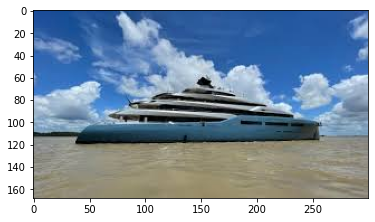

In [ ]:
img=read_image('/content/test.jpg',transform=test_transform)
predict(img)

# Đánh giá

In [40]:
def test1(net, criterion, testloader, outloader, epoch=None, **options):

    net.eval()
    correct, total = 0, 0

    torch.cuda.empty_cache()

    _pred_k, _pred_u, _labels = [], [], []

    with torch.no_grad():
        for data, labels, idx in tqdm(testloader):
            if options['use_gpu']:
                data, labels = data.cuda(), labels.cuda()
                
            
            with torch.set_grad_enabled(False):
                x, y = net(data, True)
                logits=y
                #logits, _ = criterion(x, y)
               
                predictions = logits.data.max(1)[1]
                total += labels.size(0)
                
                correct += (predictions == labels.data).sum()
                print(predictions[1])

              
                #logits = torch.nn.Softmax(dim=-1)(logits)

                _pred_k.append(logits.data.cpu().numpy())
                _labels.append(labels.data.cpu().numpy())

        for batch_idx, (data, labels, idx) in enumerate(tqdm(outloader)):
            if options['use_gpu']:
                data, labels = data.cuda(), labels.cuda()
            
            with torch.set_grad_enabled(False):

                x, y = net(data, True)
                logits=y

                #logits, _ = criterion(x, y)

                
                #logits = torch.nn.Softmax(dim=-1)(logits)

                _pred_u.append(logits.data.cpu().numpy())

    # Accuracy
    acc = float(correct) * 100. / float(total)
    print('Acc: {:.5f}'.format(acc))

    _pred_k = np.concatenate(_pred_k, 0)
    _pred_u = np.concatenate(_pred_u, 0)
    _labels = np.concatenate(_labels, 0)
    
    # Out-of-Distribution detction evaluation
    x1, x2 = np.max(_pred_k, axis=1), np.max(_pred_u, axis=1)
    results = evaluation.metric_ood(x1, x2)['Bas']
    
    # OSCR
    _oscr_socre = evaluation.compute_oscr(_pred_k, _pred_u, _labels)

    # Average precision
    ap_score = average_precision_score([0] * len(_pred_k) + [1] * len(_pred_u),
                                       list(-np.max(_pred_k, axis=-1)) + list(-np.max(_pred_u, axis=-1)))

    results['ACC'] = acc
    results['OSCR'] = _oscr_socre * 100.
    results['AUPR'] = ap_score * 100

    return results,x1,x2

In [43]:
results,x1,x2 = test1(model_mls, criterion, testloader, outloader,  **options)
print("Ket qua: Acc (%): {:.3f}\t AUROC (%): {:.3f}\t OSCR (%): {:.3f}\t".format(
                                                                                              results['ACC'],
                                                                                              results['AUROC'],
                                                                                              results['OSCR']))

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 75%|███████▌  | 6/8 [00:00<00:00, 16.88it/s]

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(1, device='cuda:0')
tensor(2, device='cuda:0')
tensor(2, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')


100%|██████████| 8/8 [00:00<00:00, 14.94it/s]


Acc: 96.80000
Ket qua: Acc (%): 96.800	 AUROC (%): 96.341	 OSCR (%): 93.769	


In [44]:
tp = np.ones([1000], dtype=int)
fp = -np.ones([1000], dtype=int)
fp=tp+fp
fp
y_test=np.append(tp,fp)
len(y_test)
pred=np.append(x1,x2)
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(y_test,pred)
roc_auc = metrics.auc(fpr, tpr)

roc_auc

0.963411

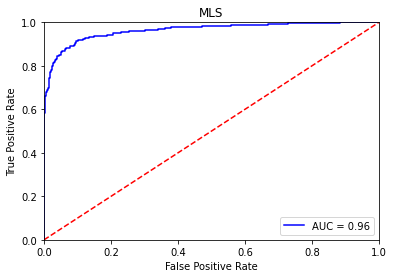

In [46]:
import matplotlib.pyplot as plt
plt.title('MLS')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()